In [5]:
%matplotlib inline

In [7]:
# from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import matplotlib.pyplot as plt
from fastai.basics import *
from fastai.callback.all import *
# from nbdev.showdoc import *
# from fastai.callbacks.hooks import *
# from fastai.utils.mem import *

In [8]:
print(torch.cuda.is_available())

True


In [13]:
path = untar_data(URLs.CAMVID)
print(f'======> The downladed data is located at {path}')
print(f'======> This folder inclodes\n {path.ls()}')

======> The downladed data is located at /home/qiao/.fastai/data/camvid
======> This folder inclodes
 [Path('/home/qiao/.fastai/data/camvid/codes.txt'), Path('/home/qiao/.fastai/data/camvid/valid.txt'), Path('/home/qiao/.fastai/data/camvid/images'), Path('/home/qiao/.fastai/data/camvid/labels')]


In [14]:
# load the image path and mask path seperately
path_img = path/'images'
path_label = path/'labels'

In [18]:
# To check the files in image_path and mask_path
fnames = get_image_files(path_img) # get_file func
print(f'======> In image path folder checking: {fnames[:3]}')
mask_names = get_image_files(path_label)
print(f'======> In mask path folder checking: {mask_names[:3]}')

======> In image path folder checking: [Path('/home/qiao/.fastai/data/camvid/images/Seq05VD_f02220.png'), Path('/home/qiao/.fastai/data/camvid/images/0016E5_05220.png'), Path('/home/qiao/.fastai/data/camvid/images/0016E5_08003.png')]
======> In mask path folder checking: [Path('/home/qiao/.fastai/data/camvid/labels/Seq05VD_f00900_P.png'), Path('/home/qiao/.fastai/data/camvid/labels/0001TP_008670_P.png'), Path('/home/qiao/.fastai/data/camvid/labels/0016E5_06570_P.png')]


In [19]:
# # 2022-04-21
# # loading kitti dataset
# # for now, there are no acceptable codes
# path = Path('/home/qiao/dev/giao/datasets/kittiseg')

# path_img = path/'training/image_2'
# path_label = path/'training/instance'
# codes = ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']
# # codes = ['unlabeled',
# #     'ego vehicle',
# #     'rectification border',
# #     'out of roi',
# #     'static',
# #     'dynamic',
# #     'ground',
# #     'road',
# #     'sidewalk',
# #     'parking',
# #     'rail track',
#     'building',
#     'wall',
#     'fence',
#     'guard rail',
#     'bridge',
#     'tunnel',
#     'pole',
#     'polegroup',
#     'traffic light',
#     'traffic sign',
#     'vegetation',
#     'terrain',
#     'sky',
#     'person',
#     'rider',
#     'car',
#     'truck',
#     'bus',
#     'caravan',
#     'trailer',
#     'train',
#     'motorcycle',
#     'bicycle',
#     'license plate']

In [24]:
# Check the code of labeled masks
codes = np.loadtxt(path/'codes.txt', dtype=str)
print(f'=======> The codes in mask:\n {codes}')

=======> The codes in mask:
 ['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car'
 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence' 'LaneMkgsDriv'
 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving'
 'ParkingBlock' 'Pedestrian' 'Road' 'RoadShoulder' 'Sidewalk' 'SignSymbol'
 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree'
 'Truck_Bus' 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


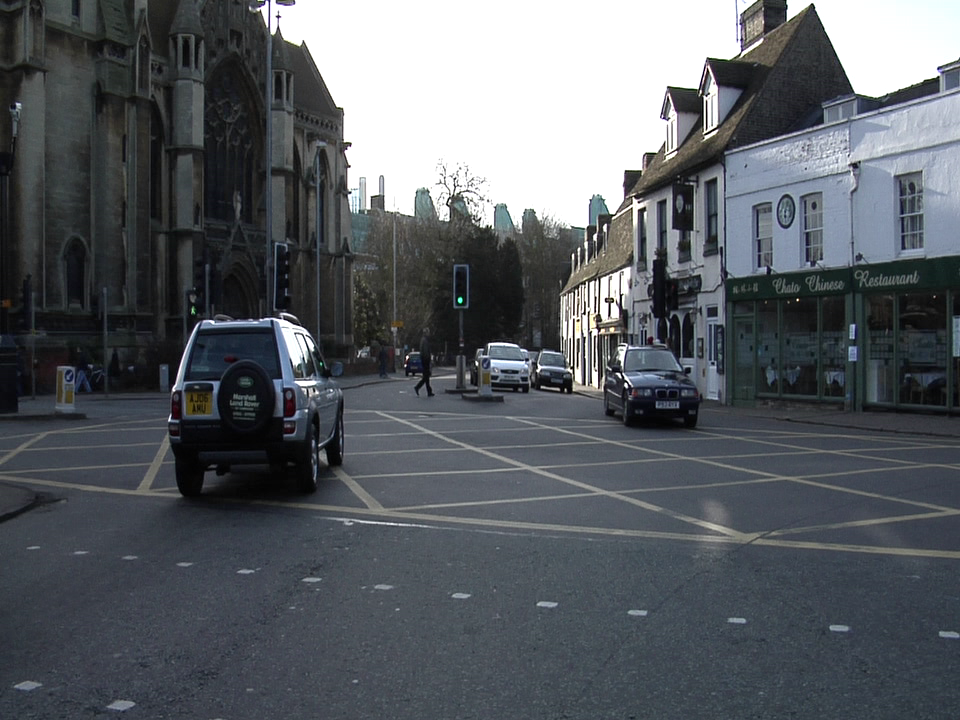

In [35]:
img_f = fnames[1]
img = Image.open(img_f)
img.show()

In [42]:
# get the related mask of the image
get_y_func = lambda x: path_label/f'{x.stem}_P{x.suffix}'

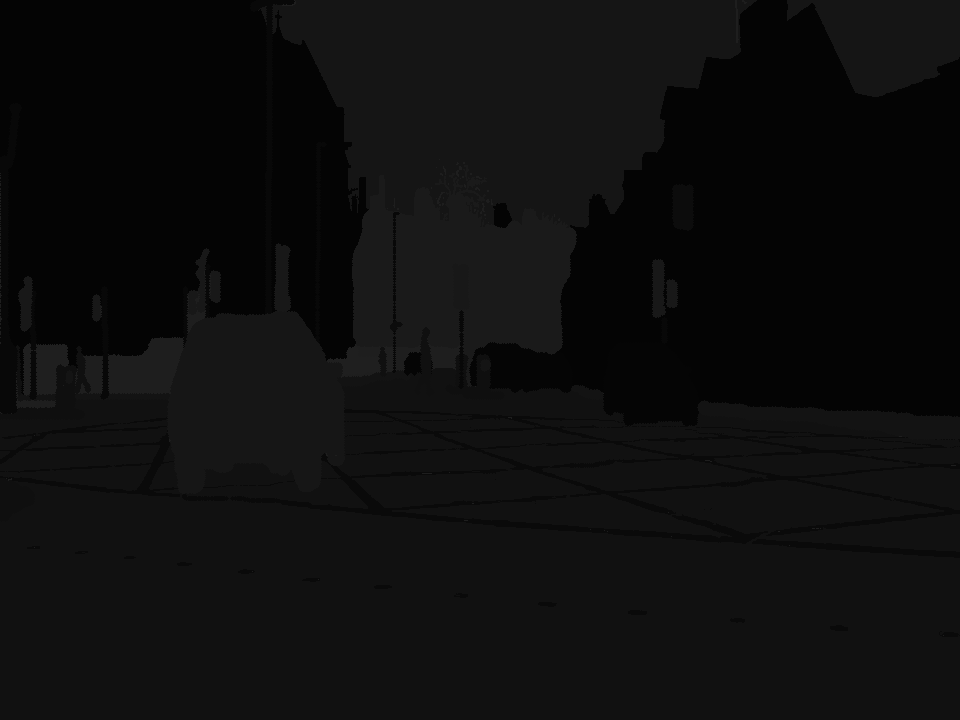

In [46]:
mask = Image.open(get_y_func(img_f))
mask.show()

In [61]:
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs = 4,
    fnames = fnames,
    label_func = get_y_func,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


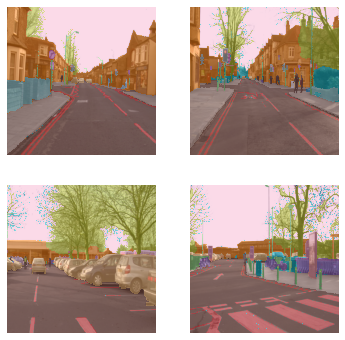

In [62]:
dls.show_batch(max_n=4)

In [63]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [64]:
learn = unet_learner(dls, models.resnet34, metrics = metrics)

In [65]:
device = "cuda" if torch.cuda.is_available () else "cpu"
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=1.3593564290204085e-05)

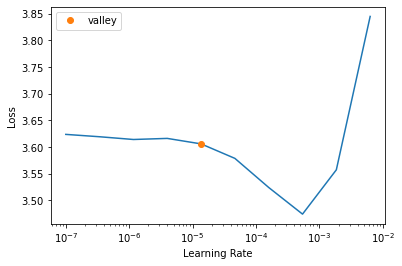

In [70]:
learn.lr_find(stop_div=False, num_it=15)

In [71]:
lr = 2e-4
learn.fit_one_cycle(13, slice(lr))

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


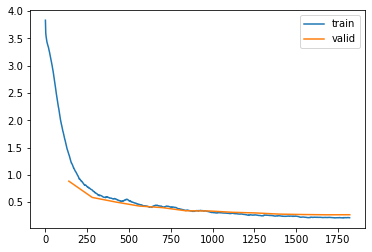

In [72]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [73]:
learn.save('stage-1')
learn.load('stage-1')

SuggestedLRs(valley=6.918309736647643e-06)

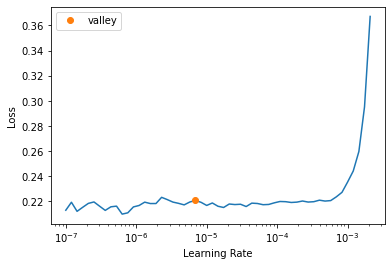

In [74]:
learn.unfreeze()
learn.lr_find()

In [75]:
lr_max = 6.9e-6

In [76]:
learn.fit_one_cycle(4, lr_max)

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


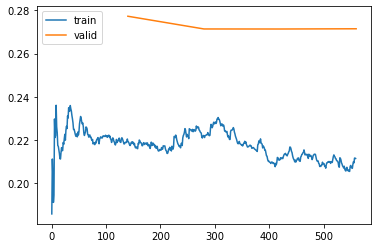

In [77]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


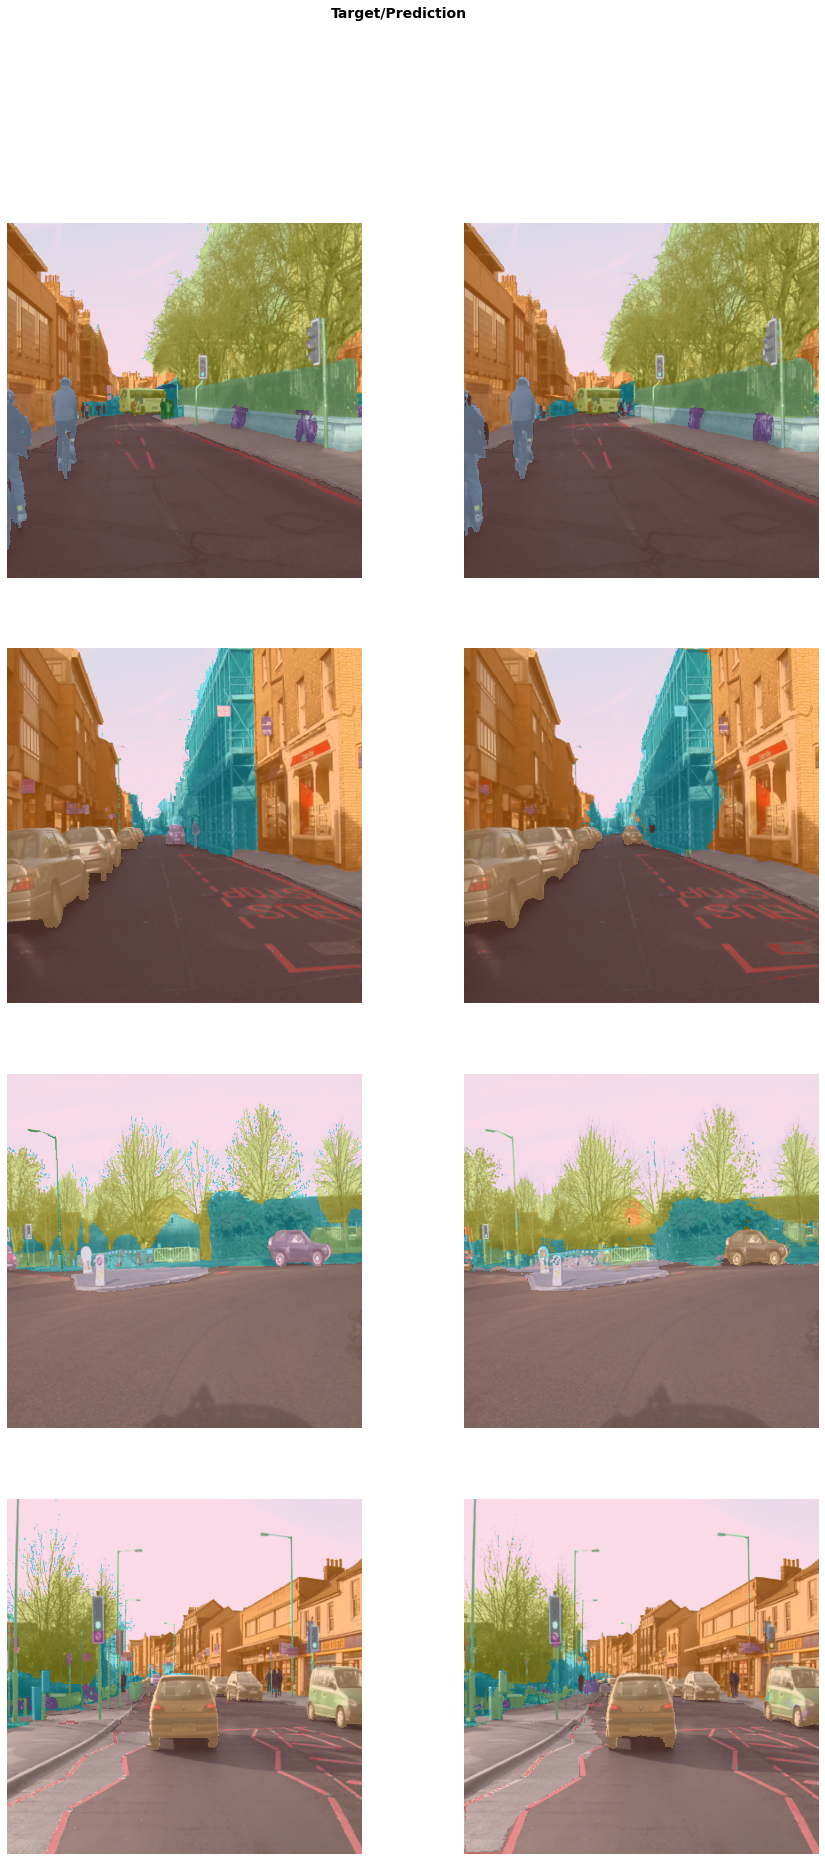

In [87]:
learn.show_results(figsize=(15, 30))

In [88]:
learn.save('U34_kitti')

Path('/home/qiao/.fastai/data/camvid/models/U34_kitti.pth')

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


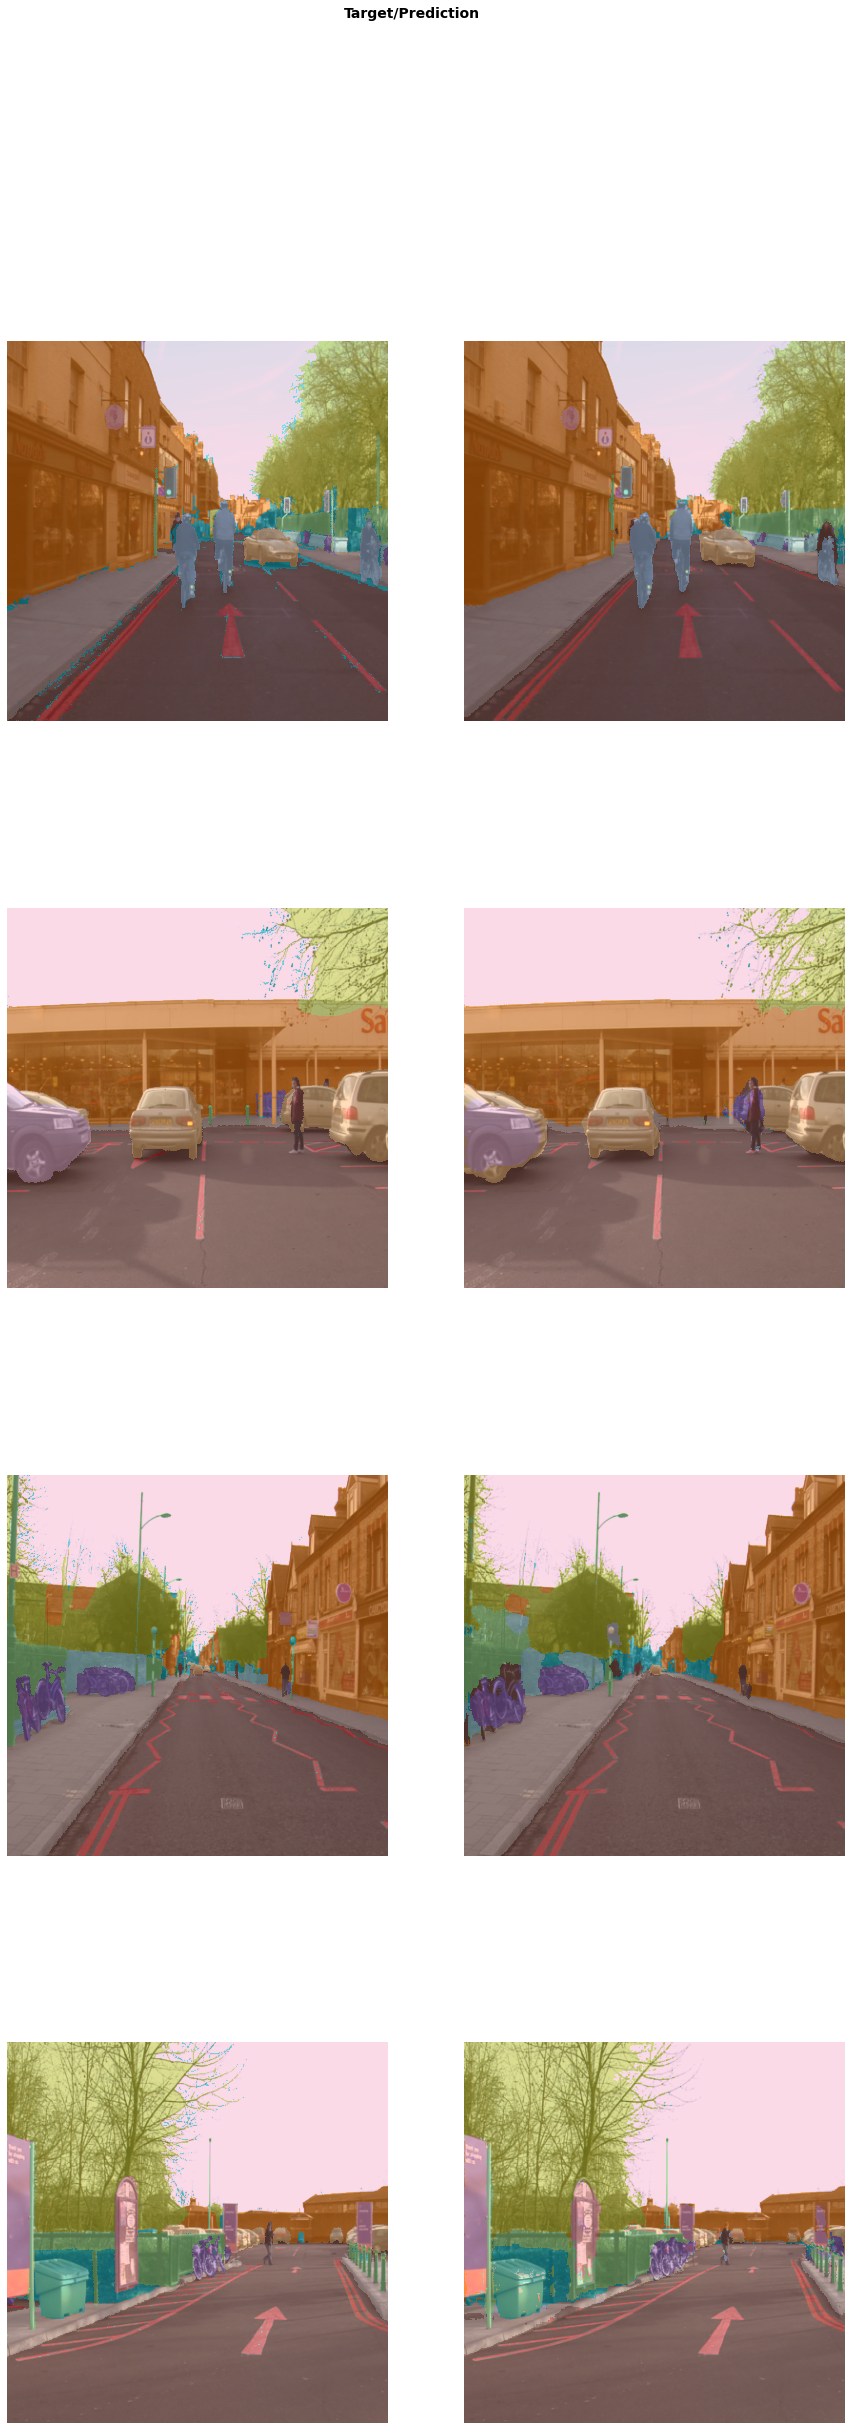

In [92]:
# learn.show_results()
learn.load('U34_kitti')
learn.show_results(figsize = (15, 40))

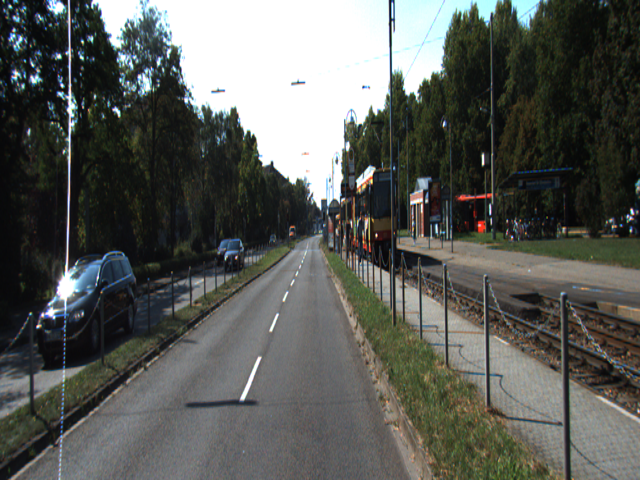

In [100]:
img = Image.open('/home/qiao/dev/giao/datasets/kittiseg/testing/image_2/000003_10.png')
img.show()

In [101]:
img = PILImage(img)

In [102]:
learn.load('U34_kitti')
# learn.load('attunet')

In [ ]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
# torch.Tensor.ndim = property(lambda self: len(self.shape))
# plt.figure(figsize=(640, 480))
print(seg_map.size())
plt.imgshow(seg_map)